In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

plt.style.use('ggplot')
%matplotlib inline

In [8]:
class LDA:
    def fit(self, df, target_col):
        self.target_col = target_col
        X = df.drop(target_col, axis=1)
        y = df[target_col]
        
        # definição de Sb Sw
        n_features = X.shape[1]
        sb = np.zeros((n_features, n_features))
        sw = np.zeros((n_features, n_features))

        # Vetor de media (eixo X)
        w, h = X.shape
        centroide = X.mean()

        # classe
        for ix, gp in df.groupby(target_col):
            X_i = gp.drop(target_col, axis=1)
            
            # eixo Xi
            class_mean = X_i.mean()

            # classe intermediária matriz Sb
            sb_i = (class_mean - centroide).values.reshape(-1, 1)
            sb += len(gp) * (sb_i @ sb_i.T)

            # entre classes matriz Sw
            sw_i = (X_i - class_mean).values
            sw += sw_i.T @ sw_i
            
        # calc autovalores e autovetores
        self.w, self.v = np.linalg.eig(np.linalg.inv(sw) @ sb)

        # calc melhor comp.
        self.variance_explained = self.w/self.w.sum()
        print('% best LDAs: {}'.format(self.variance_explained.round(4)*100))
        
        self.sw = sw
        self.sb = sb
        
    def transform(self, X, n_components=2):
        X = X.drop(self.target_col, axis=1, errors='ignore')

        # select best components
        self.W = self.v[:, self.w.argsort()[::-1][:n_components]]
        transformed = X @ self.W
        transformed.columns = [f'LDA{i}' for i in range(1, n_components+1)]

        return transformed

In [11]:
# Leitura de dados
df = pd.read_html('http://en.wikipedia.org/wiki/Iris_flower_data_set', encoding='UTF-8', index_col=0, header=0)[0]

# Tratamento da label
df.Species = df.Species.str.split('\xa0', expand=True)[1].str.capitalize()

X = df.drop('Species', axis=1)
y = df.Species.factorize()[0]

In [13]:
# LDA implementado
lda = LDA()
lda.fit(df, 'Species')
my_result = lda.transform(df, 2)
my_result['Species'] = df.Species.values

% best LDAs: [99.12  0.88  0.    0.  ]


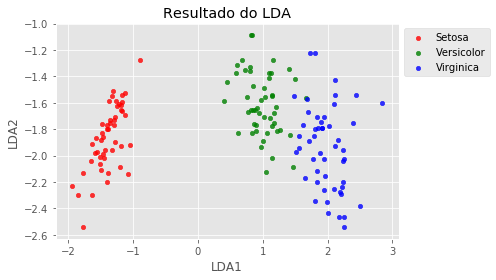

In [14]:
# Figura
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7, 4))

# Imprimir a imagem 
for species, c in zip(df.Species.drop_duplicates(), ['r', 'g', 'b']):
    my_result.query('Species==@species').plot.scatter(0, 1, alpha=.8, color=c, ax=ax, label=species)

ax.set_title('Resultado do LDA')
_ = plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('mypca_r.png')